# Introduction

# Setup
Let us import the required modules.

In [1]:
import pandas as pd
import seaborn as sns
import os
import joblib

import src.data_split as ds
import src.evaluation as eva

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, f1_score

## Load Data
Note that the dataset is already split into Train-Test sets.

In [3]:
data_split = ds.TrainTestSplit.from_csv_directory(dir_path="../data")

In [4]:
data_split.x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

In [5]:
data_split.y_train.shape

(60000,)

# Support Vector Machine Classifier Model

## Tuning Discriminative Classifiers: SVM and Random Forest

Use a smaller dataset due to the workload of GridSearchCV on SVC

In [6]:
whole_data = data_split.x_train.copy()

In [7]:
whole_data["Number"] = data_split.y_train

In [8]:
data_split.x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

In [9]:
whole_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 720 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

<AxesSubplot:xlabel='Number', ylabel='count'>

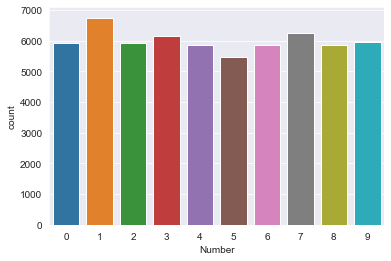

In [10]:
sns.countplot(x=whole_data["Number"])

In [11]:
data_small = whole_data.groupby('Number', group_keys=False).apply(lambda x: x.sample(500))
data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 9766 to 23761
Data columns (total 720 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64


<AxesSubplot:xlabel='Number', ylabel='count'>

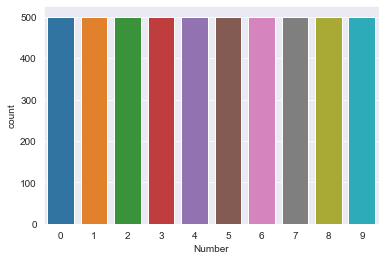

In [12]:
sns.countplot(x=data_small["Number"])

In [102]:
y_data_small = data_small["Number"].copy()
x_data_small = data_small.drop(columns=['Number'])

In [111]:
x_data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 35 

In [112]:
y_data_small.shape

(5000,)

In [113]:
y_data_small

array([0, 0, 0, ..., 9, 9, 9])

## SVM  using Linear kernel
LinearSVC is another (faster) implementation of Support Vector Classification for the case of a linear kernel

In [17]:
# import time
#
# # automatic parameters tuning
# svcclsf_lin=SVC(random_state=28)
# properties={
#     "C": [0.01,0.05,0.1,0.5,1,10,100,1000], # soft to hard margin
#     "kernel": ["linear"]
# }
#
# start_time = time.time()
# tuned_svcclsf_lin=GridSearchCV(svcclsf_lin,properties,scoring="f1_weighted",cv=10,return_train_score=True,verbose=6,n_jobs=4)
# tuned_svcclsf_lin.fit(x_data_small,y_data_small)
# print("--- %s seconds ---" % (time.time() - start_time))
#
# print ("Best Score: {:.3f}".format(tuned_svcclsf_lin.best_score_) )
# print ("Best Params: ", tuned_svcclsf_lin.best_params_)

In [18]:
# save results
# if not os.path.exists('../tuned_models'):
#     os.mkdir('../tuned_models')
# joblib.dump(tuned_svcclsf_lin, '../tuned_models/svc_linear_tuning_results.pkl')

In [19]:
# to load previously saved results
tuned_svcclsf_lin = joblib.load("../tuned_models/svc_linear_tuning_results.pkl")

In [20]:
print(tuned_svcclsf_lin.cv_results_)
tuned_svcclsf_lin_results = pd.DataFrame( tuned_svcclsf_lin.cv_results_ )

{'mean_fit_time': array([6.04955266, 5.29069901, 4.6443712 , 6.34782059, 4.41250651,
       5.04624975, 4.26613345, 4.32742345]), 'std_fit_time': array([1.90790705, 1.48820078, 0.65715774, 1.69210032, 0.46206075,
       1.2007513 , 0.277341  , 0.78741452]), 'mean_score_time': array([1.50803292, 0.96820037, 1.13122513, 0.83798137, 0.79181385,
       1.00419908, 0.88259835, 0.7365994 ]), 'std_score_time': array([0.58668017, 0.25155559, 0.38067211, 0.07232036, 0.0786334 ,
       0.30735826, 0.23699288, 0.07520747]), 'param_C': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'linear',
                   'linear', 'linear', 'linear'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01, 

In [21]:
tuned_svcclsf_lin_results[["params","mean_test_score","mean_train_score"]]

,param_C,mean_test_score,mean_train_score
0,0.01,0.912086,0.936985
1,0.05,0.918673,0.964898
2,0.1,0.916277,0.980775
3,0.5,0.904567,0.998422
4,1,0.903080,0.999911
5,10,0.903903,1.000000
6,100,0.903903,1.000000
7,1000,0.903903,1.000000


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

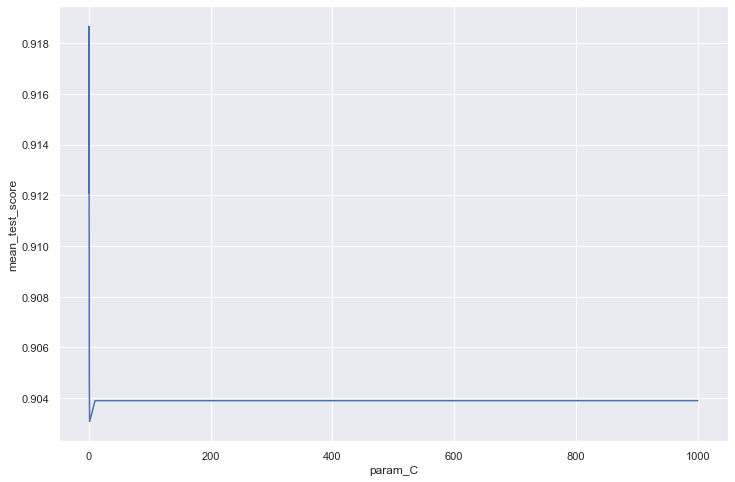

In [22]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_lin_results, x="param_C", y="mean_test_score")

In [23]:
print(tuned_svcclsf_lin.best_estimator_)
print(tuned_svcclsf_lin.best_score_)

SVC(C=0.05, kernel='linear', random_state=28)
0.9186726738413699


In [25]:
test_acc = f1_score(y_true = data_split.y_train,
                    y_pred = tuned_svcclsf_lin.predict(data_split.x_train),
                    average='weighted')
print ("Train Accuracy on original dataset: {}".format(test_acc) )

Train Accuracy on original dataset: 0.9271517506440023


In [26]:
# best parameters from automatic parameters tuning
svc_lin_clsf = SVC(**tuned_svcclsf_lin.best_params_)
# svc_lin_clsf = SVC(C=0.05, kernel='linear', random_state=28)

svc_lin_clsf.fit(data_split.x_train, data_split.y_train)

SVC(C=0.05, kernel='linear')

In [27]:
svc_lin_train_pred = svc_lin_clsf.predict(data_split.x_train)
svc_lin_test_pred = svc_lin_clsf.predict(data_split.x_test)

In [28]:
print("Training:")
print('F1 Score: {}'.format(f1_score(y_true = data_split.y_train,
                                           y_pred = svc_lin_train_pred,
                                           average='weighted')))

Training:
F1 Score: 0.9556304025493505


In [29]:
print("Testing:")
print('F1 Score: {}'.format(f1_score(y_true = data_split.y_test,
                                     y_pred = svc_lin_test_pred,
                                     average='weighted')))

Testing:
F1 Score: 0.940576194514731


## SVM using Polynomial of degree 2 kernel

In [47]:
# import time
#
# # automatic parameters tuning
# svcclsf_pol=SVC(random_state=28)
# properties={
#     "C": [0.01,0.05,0.1,0.5,1,10,100,1000], # soft to hard margin
#     "kernel": ["poly"],
#     "degree": [2],
#     "gamma": ["auto",0.1,1]
# }
#
# start_time = time.time()
# tuned_svcclsf_pol=GridSearchCV(svcclsf_pol,properties,scoring="f1_weighted",cv=10,return_train_score=True,verbose=6,n_jobs=4)
# tuned_svcclsf_pol.fit(x_data_small,y_data_small)
# print("--- %s seconds ---" % (time.time() - start_time))
#
# print ("Best Score: {:.3f}".format(tuned_svcclsf_pol.best_score_) )
# print ("Best Params: ", tuned_svcclsf_pol.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
--- 1097.8459870815277 seconds ---
Best Score: 0.950
Best Params:  {'C': 0.05, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}


In [70]:
# # save results
# if not os.path.exists('../tuned_models'):
#     os.mkdir('../tuned_models')
# joblib.dump(tuned_svcclsf_pol, '../tuned_models/svc_polynomial_tuning_results.pkl')

['../tuned_models/svc_polynomial_tuning_results.pkl']

In [72]:
# to load previously saved results
tuned_svcclsf_pol = joblib.load("../tuned_models/svc_polynomial_tuning_results.pkl")

In [73]:
print(tuned_svcclsf_pol.cv_results_)
tuned_svcclsf_pol_results = pd.DataFrame( tuned_svcclsf_pol.cv_results_ )

{'mean_fit_time': array([24.1586782 ,  4.68150933,  3.30426054, 30.46786444,  4.16735358,
        3.29985554, 23.19657018,  3.91261182,  3.99924769, 25.2089462 ,
        3.82932179,  3.94053969, 20.97119267,  4.00709753,  3.56156936,
        9.6439209 ,  3.72265992,  3.92893999,  4.80152278,  3.98152876,
        3.60740249,  4.08431277,  4.02713363,  3.67558684]), 'std_fit_time': array([2.3761632 , 0.3853937 , 0.18261219, 2.33401725, 0.96882428,
       0.10737138, 0.66342447, 0.27617695, 0.43593049, 0.69391413,
       0.19488316, 0.42796174, 0.17053982, 0.33984398, 0.08741394,
       0.47722778, 0.10922738, 0.06048179, 0.42009294, 0.2571172 ,
       0.1567817 , 0.32246639, 0.31596841, 0.53646132]), 'mean_score_time': array([2.16694393, 0.64109995, 0.51306727, 2.24939609, 0.56262767,
       0.50046759, 1.94545007, 0.69747705, 0.56927798, 2.1113687 ,
       0.5939255 , 0.59210157, 2.1352294 , 0.59091153, 0.58225088,
       1.15213554, 0.61337218, 0.63434074, 0.86314883, 0.59705753,
     

In [74]:
tuned_svcclsf_pol_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,"{'C': 0.01, 'degree': 2, 'gamma': 'auto', 'ker...",0.440146,0.450122
1,"{'C': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel...",0.937970,0.968242
2,"{'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel':...",0.949486,1.000000
3,"{'C': 0.05, 'degree': 2, 'gamma': 'auto', 'ker...",0.440146,0.450122
4,"{'C': 0.05, 'degree': 2, 'gamma': 0.1, 'kernel...",0.949634,0.996668
5,"{'C': 0.05, 'degree': 2, 'gamma': 1, 'kernel':...",0.949486,1.000000
6,"{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kern...",0.440146,0.450122
7,"{'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel'...",0.949095,0.999644
8,"{'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': ...",0.949486,1.000000
9,"{'C': 0.5, 'degree': 2, 'gamma': 'auto', 'kern...",0.572298,0.582482


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

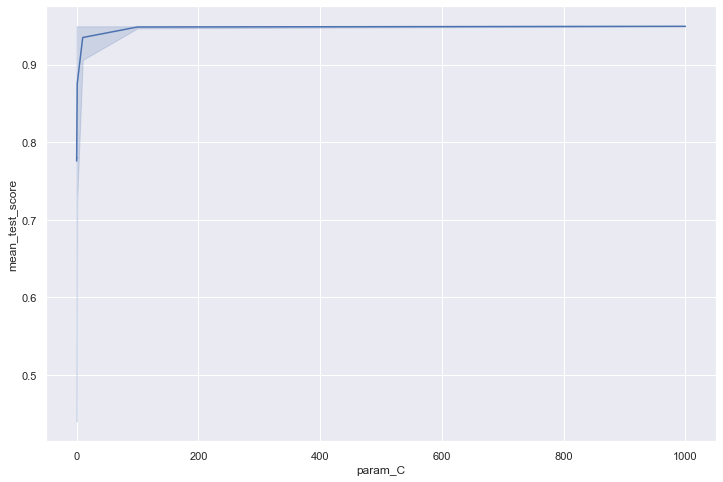

In [75]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_pol_results, x="param_C", y="mean_test_score")

In [76]:
print(tuned_svcclsf_pol.best_estimator_)
print(tuned_svcclsf_pol.best_score_)

SVC(C=0.05, degree=2, gamma=0.1, kernel='poly', random_state=28)
0.949634369508955


In [77]:
test_acc = accuracy_score(y_true = data_split.y_train,
                          y_pred = tuned_svcclsf_pol.predict(data_split.x_train) )
print ("Train Accuracy: {}".format(test_acc) )

Train Accuracy: 0.9547166666666667


In [56]:
# best parameters from automatic parameters tuning
svc_pol_clsf = SVC(**tuned_svcclsf_pol.best_params_)
# svc_pol_clsf = SVC(C=0.05, degree=2, gamma=0.1, kernel='poly', random_state=28)

svc_pol_clsf.fit(data_split.x_train, data_split.y_train)

SVC(C=0.05, degree=2, gamma=0.1, kernel='poly')

In [80]:
svc_pol_train_pred = svc_pol_clsf.predict(data_split.x_train)
svc_pol_test_pred = svc_pol_clsf.predict(data_split.x_test)

In [81]:
print("Training:")
print('F1 Score: {}'.format(f1_score(y_true = data_split.y_train,
                                           y_pred = svc_pol_train_pred,
                                           average='weighted')))

Training:
F1 Score: 0.9957497486165561


In [82]:
print("Testing:")
print('F1 Score: {}'.format(f1_score(y_true = data_split.y_test,
                                     y_pred = svc_pol_test_pred,
                                     average='weighted')))

Testing:
F1 Score: 0.9799929603024202


## SVM  using  RBF kernel

In [48]:
# import time
#
# # automatic parameters tuning
# svcclsf_rbf=SVC(random_state=28)
# properties={
#     "C": [0.01,0.05,0.1,0.5,1,10,100,1000], # soft to hard margin
#     "kernel": ["rbf"],
#     "gamma": ["auto",0.1,1]
# }
#
# start_time = time.time()
# tuned_svcclsf_rbf=GridSearchCV(svcclsf_rbf,properties,scoring="f1_weighted",cv=10,return_train_score=True,verbose=6,n_jobs=4)
# tuned_svcclsf_rbf.fit(x_data_small,y_data_small)
# print("--- %s seconds ---" % (time.time() - start_time))
#
# print ("Best Score: {:.3f}".format(tuned_svcclsf_rbf.best_score_) )
# print ("Best Params: ", tuned_svcclsf_rbf.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
--- 2330.964450120926 seconds ---
Best Score: 0.936
Best Params:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [83]:
# # save results
# if not os.path.exists('../tuned_models'):
#     os.mkdir('../tuned_models')
# joblib.dump(tuned_svcclsf_rbf, '../tuned_models/svc_rbf_tuning_results.pkl')

['../tuned_models/svc_rbf_tuning_results.pkl']

In [84]:
# to load previously saved results
tuned_svcclsf_rbf = joblib.load("../tuned_models/svc_rbf_tuning_results.pkl")

In [85]:
print(tuned_svcclsf_rbf.cv_results_)
tuned_svcclsf_rbf_results = pd.DataFrame( tuned_svcclsf_rbf.cv_results_ )

{'mean_fit_time': array([21.12724845, 21.28439002, 21.52958717, 18.71232872, 19.86977935,
       20.82048597, 14.91914546, 18.71652584, 19.21768761,  7.13077497,
       19.25392275, 21.30227852,  6.13925252, 22.69810863, 22.3177738 ,
        2.95412762, 22.68043957, 22.95533314,  2.50384336, 20.02614877,
       20.02982709,  2.60203719, 20.46544261, 19.97337227]), 'std_fit_time': array([0.14435927, 0.19348382, 1.57281707, 0.18447708, 0.19902127,
       0.88216291, 0.28858617, 0.15047183, 0.32637887, 0.3613568 ,
       1.29329829, 1.65152106, 0.38107104, 1.50006316, 1.04516295,
       0.22502137, 0.40300741, 1.06313627, 0.3365184 , 0.17586783,
       0.23236055, 0.42460939, 1.01201396, 1.00874195]), 'mean_score_time': array([2.4564003 , 2.54873149, 2.38083212, 2.22428696, 2.20041347,
       2.44014301, 2.10323274, 2.14482789, 2.210481  , 1.74313872,
       2.14235749, 2.83180258, 1.55173357, 2.47162917, 2.77887943,
       0.96369407, 2.49825857, 2.70048964, 0.82907383, 2.25434687,
     

In [86]:
tuned_svcclsf_rbf_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.735612,0.740519
1,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}",0.532943,0.810455
2,"{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",0.035221,1.000000
3,"{'C': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}",0.769960,0.776130
4,"{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}",0.542711,0.821859
5,"{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}",0.035221,1.000000
6,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.816860,0.823737
7,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.553150,0.832869
8,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.035221,1.000000
9,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.892212,0.903162


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

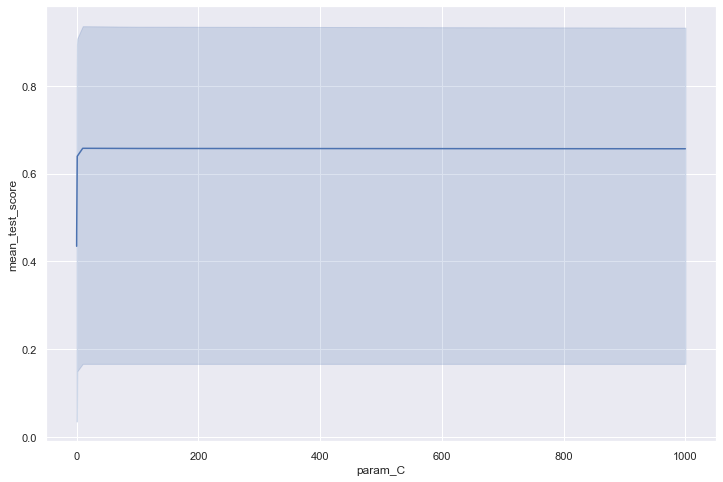

In [87]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_rbf_results, x="param_C", y="mean_test_score")

In [88]:
print(tuned_svcclsf_rbf.best_estimator_)
print(tuned_svcclsf_rbf.best_score_)

SVC(C=10, gamma='auto', random_state=28)
0.9360897769343038


In [89]:
test_acc = accuracy_score(y_true = data_split.y_train,
                          y_pred = tuned_svcclsf_rbf.predict(data_split.x_train) )
print ("Train Accuracy: {}".format(test_acc) )

Train Accuracy: 0.93475


In [90]:
# best parameters from automatic parameters tuning
svc_rbf_clsf = SVC(**tuned_svcclsf_rbf.best_params_)
# svc_rbf_clsf = SVC(max_leaf_nodes=100, min_samples_leaf=75, n_estimators=200, random_state=28)

svc_rbf_clsf.fit(data_split.x_train, data_split.y_train)

SVC(C=10, gamma='auto')

In [91]:
svc_rbf_train_pred = svc_rbf_clsf.predict(data_split.x_train)
svc_rbf_test_pred = svc_rbf_clsf.predict(data_split.x_test)

In [92]:
print("Training:")
print('F1 Score: {}'.format(f1_score(y_true = data_split.y_train,
                                           y_pred = svc_rbf_train_pred,
                                           average='weighted')))

Training:
F1 Score: 0.9725401044710673


In [93]:
print("Testing:")
print('F1 Score: {}'.format(f1_score(y_true = data_split.y_test,
                                     y_pred = svc_rbf_test_pred,
                                     average='weighted')))

Testing:
F1 Score: 0.9614637982793142


# Performance Visualization

### Setup